## 🔬 Visualizzazione della Policy Ottimale (Q-Table)

Dopo aver completato la fase di addestramento (o caricando una Q-table pre-addestrata), il nostro agente ha imparato i valori $Q(s, a)$. Ma cosa rappresentano questi valori e come si traducono in un comportamento effettivo?

### Dalla Q-Table alla Policy

La **Q-Table** (o funzione Q) è una tabella (nel nostro caso, una matrice NumPy) che memorizza il **valore atteso di ritorno (reward futuro accumulato)** per ogni possibile coppia stato-azione $(s, a)$. In altre parole, $Q(s, a)$ ci dice "quanto è buono" compiere l'azione $a$ quando ci troviamo nello stato $s$, e poi continuare a seguire la politica ottimale.

Una volta che abbiamo una Q-Table "convergente" (cioè addestrata a sufficienza), possiamo estrarre la **policy ottimale** ($\pi^*$) in modo molto semplice. La policy non è altro che una mappa che ci dice quale azione compiere in ogni stato. Per un agente che vuole massimizzare il proprio guadagno, la scelta migliore in ogni stato $s$ è semplicemente l'azione $a$ che ha il valore $Q(s, a)$ più alto.

Questa è nota come **politica greedy** (ingorda):
$$\pi^*(s) = \arg\max_a Q(s, a)$$

Il codice `np.argmax(Q[s])` implementa esattamente questa formula: per un dato stato `s`, trova l'indice (l'azione) che ha il valore massimo in quella riga della Q-table.

### Il Contesto di Taxi-v3

L'ambiente "Taxi-v3" ha **500 stati possibili**. Questo numero non è casuale, ma deriva dalla combinazione di 4 variabili:
* **Posizione riga taxi:** 5 possibilità (0-4)
* **Posizione colonna taxi:** 5 possibilità (0-4)
* **Posizione passeggero:** 5 possibilità (0-3 per le 4 location, + 4 se è a bordo)
* **Destinazione passeggero:** 4 possibilità (0-3)

Quindi $5 \times 5 \times 5 \times 4 = 500$ stati.

### Obiettivo del Codice

Poiché la politica ottimale dipende non solo da *dove si trova il taxi*, ma anche da *dove si trova il passeggero* e *dove deve andare*, visualizzare tutti i 500 stati è complicato.

Il codice seguente semplifica questa visualizzazione creando **due "mappe" separate**:
1.  **Policy (prima del pickup):** Mostra l'azione migliore in ogni cella $(riga, colonna)$ assumendo che il passeggero *non sia* ancora a bordo.
2.  **Policy (con passeggero a bordo):** Mostra l'azione migliore in ogni cella $(riga, colonna)$ assumendo che il passeggero *sia* a bordo.

Per fare questo, il codice:
* Carica la `Q-table` addestrata dal file.
* Inizializza due griglie 5x5.
* Itera attraverso tutti i 500 stati.
* Per ogni stato, usa la funzione `decode_state` per capire la posizione del taxi e se il passeggero è a bordo.
* Calcola l'azione migliore (greedy) con `np.argmax(Q[s])`.
* Assegna il simbolo dell'azione (`←`, `↓`, `→`, `↑`, `P`, `D`) alla griglia appropriata in base alla posizione del taxi.
* Infine, usa `matplotlib` per disegnare le due mappe, evidenziando le 4 location speciali (R, G, Y, B).




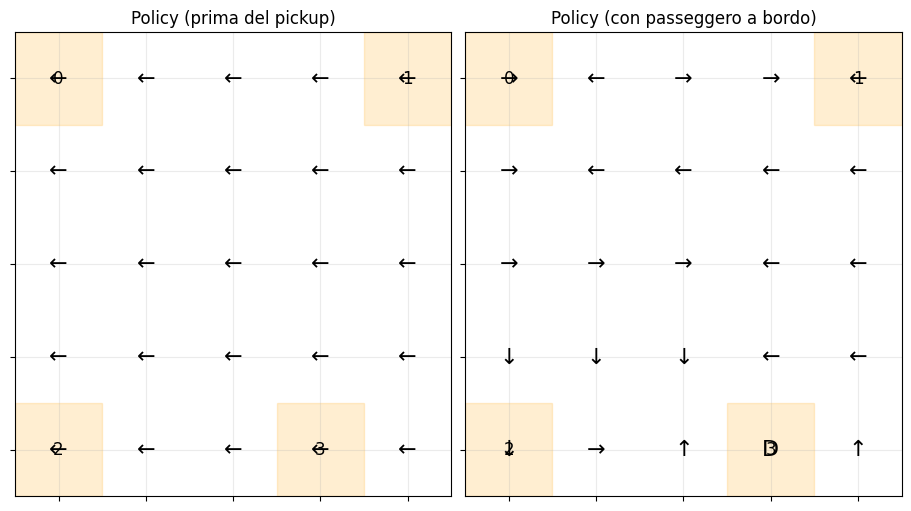

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# Carica Q (o usa quello già in memoria)
data = np.load("qtable_taxi.npz", allow_pickle=True)
Q = data["Q"]

env = gym.make("Taxi-v3")
n_states = env.observation_space.n

# decode Taxi-v3 state -> (taxi_row, taxi_col, passenger_loc, dest_loc)
def decode_state(s: int):
    out = []
    out.append(s % 4); s //= 4         # dest 0..3
    out.append(s % 5); s //= 5         # passenger 0..4 (4 = on taxi)
    out.append(s % 5); s //= 5         # taxi_col 0..4
    out.append(s)                      # taxi_row 0..4
    taxi_row, taxi_col, pass_loc, dest = list(reversed(out))
    return taxi_row, taxi_col, pass_loc, dest

# simboli per tutte le 6 azioni
symbol = {0:'←', 1:'↓', 2:'→', 3:'↑', 4:'P', 5:'D'}  # P=pickup, D=dropoff

N = 5
pre_grid   = np.full((N, N), '·', dtype='<U2')  # passeggero a terra
carry_grid = np.full((N, N), '·', dtype='<U2')  # passeggero a bordo

# Per ogni stato scegli l'azione greedy e riempi la cella corrispondente
# (se più stati mappano alla stessa cella, vince l'ultimo: va bene per una vista rapida)
for s in range(n_states):
    tr, tc, pass_loc, _ = decode_state(s)
    a = int(np.argmax(Q[s]))  # 0..5
    if pass_loc < 4:
        pre_grid[tr, tc]   = symbol[a]
    else:
        carry_grid[tr, tc] = symbol[a]

# Disegna le due mappe fianco a fianco
fig, axes = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
titles = ["Policy (prima del pickup)", "Policy (con passeggero a bordo)"]
for k, grid in enumerate([pre_grid, carry_grid]):
    ax = axes[k]
    ax.set_xticks(np.arange(N)+0.5, minor=False); ax.set_yticks(np.arange(N)+0.5, minor=False)
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_xlim(0, N); ax.set_ylim(N, 0)
    ax.grid(True, which='both', alpha=0.25)
    for r in range(N):
        for c in range(N):
            ax.text(c+0.5, r+0.5, grid[r, c], ha='center', va='center', fontsize=16)
    # evidenzia le 4 locazioni speciali
    locs = [(0,0),(0,4),(4,0),(4,3)]
    for idx, (rr, cc) in enumerate(locs):
        ax.add_patch(plt.Rectangle((cc, rr), 1, 1, fill=True, color='orange', alpha=0.18))
        ax.text(cc+0.5, rr+0.5, str(idx), ha='center', va='center', fontsize=12, color='black')
    ax.set_title(titles[k])

plt.show()

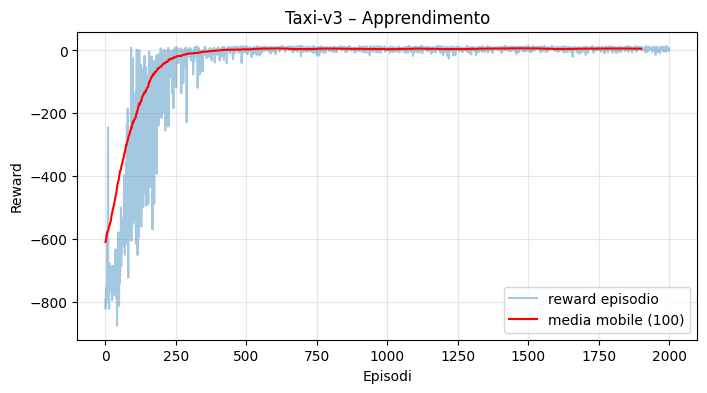

✅ Reward medio (ultimi 100): 5.45


In [37]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("qtable_taxi.npz", allow_pickle=True)
rewards = data["rewards"]

window = 100
moving = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,4))
plt.plot(rewards, alpha=0.4, label='reward episodio')
plt.plot(moving, color='red', label=f'media mobile ({window})')
plt.xlabel('Episodi'); plt.ylabel('Reward'); plt.title('Taxi-v3 – Apprendimento')
plt.legend(); plt.grid(alpha=0.3); plt.show()

print(f"✅ Reward medio (ultimi 100): {np.mean(rewards[-100:]):.2f}")


In [38]:
import os, json
import numpy as np

# === PATH ESPORTAZIONE ===
target_dir = os.path.join("..", "experiments", "taxi_v3", "data")
os.makedirs(target_dir, exist_ok=True)
target_path = os.path.join(target_dir, "taxi_v3_results.json")

# === AGGREGAZIONE Q PER CELLA ===
agg = {}
for s in range(n_states):
    tr, tc, pass_loc, _ = decode_state(s)
    best_action = int(np.argmax(Q[s]))
    best_value = float(np.max(Q[s]))
    key = (tr, tc)
    if key not in agg:
        agg[key] = []
    agg[key].append(best_value)

# media del valore per ogni cella
policy_export = []
for (r, c), vals in agg.items():
    avg_val = float(np.mean(vals))
    best_state = np.argmax([np.max(Q[s]) for s in range(n_states) if decode_state(s)[:2] == (r, c)])
    best_action = int(np.argmax(Q[best_state]))
    policy_export.append({
        "row": int(r),
        "col": int(c),
        "action": best_action,
        "value": round(avg_val, 4)
    })

# === METADATA + REWARD ===
export = {
    "metadata": {
        "env": "Taxi-v3",
        "states": int(n_states),
        "actions": 6,
        "cells": len(policy_export)
    },
    "policy": policy_export,
    "rewards": rewards.tolist(),
    "reward_avg_last100": float(np.mean(rewards[-100:]))
}

# === SALVA JSON ===
with open(target_path, "w", encoding="utf-8") as f:
    json.dump(export, f, indent=2)

print(f"✅ Esportato {len(policy_export)} celle aggregate → {target_path}")


✅ Esportato 25 celle aggregate → ..\experiments\taxi_v3\data\taxi_v3_results.json


## 🏃‍♂️ Esecuzione e Test della Policy (Exploitation)

Avere una Q-table addestrata e una mappa della policy (come quella visualizzata nella cella precedente) è utile, ma il vero test è vedere l'agente in azione. Vogliamo verificare se la policy appresa è *efficace* nel risolvere il compito in un episodio completo, partendo da uno stato iniziale.

### Dalla Teoria alla Pratica: L'Exploitation

Questa cella esegue un singolo episodio in modalità di **exploitation pura**.

Ricordiamo che durante l'addestramento (Q-learning), l'agente usa tipicamente una strategia (come *Epsilon-Greedy*) per bilanciare due necessità:
1.  **Exploration (Esplorazione):** Provare azioni casuali per scoprire nuovi percorsi e reward, aggiornando la Q-table.
2.  **Exploitation (Sfruttamento):** Usare la conoscenza già acquisita (la Q-table) per scegliere l'azione che si ritiene migliore.

Ora che l'addestramento è terminato, **disattiviamo completamente l'esplorazione**. Ci interessa solo "sfruttare" la conoscenza accumulata. In ogni stato `s`, l'agente sceglierà *sempre* l'azione `a` che massimizza il valore Q, seguendo la policy ottimale (greedy) che abbiamo imparato:

$$\pi^*(s) = \arg\max_a Q(s, a)$$

La linea di codice `action = int(np.argmax(Q[state]))` implementa esattamente questa logica.

### Obiettivo del Codice

L'obiettivo di questa cella è duplice:
* **Misurare le prestazioni:** Eseguiamo un episodio (con un limite massimo di 100 passi) e calcoliamo il `total_reward` ottenuto. Questo ci dà una misura quantitativa dell'efficienza della nostra policy.
* **Tracciare il percorso:** Memorizziamo ogni singolo passo (posizione, azione, reward ottenuto) nella lista `trajectory`.

Questa traiettoria è fondamentale per l'analisi qualitativa (per *vedere* il percorso scelto dall'agente) e verrà salvata nel file JSON finale. Questo permetterà ad altri strumenti, come la dashboard web, di caricare e riprodurre visivamente l'episodio.

In [39]:
import random

trajectory = []
state, info = env.reset(seed=42)
done = False
total_reward = 0

for t in range(100):  # max steps
    tr, tc, pass_loc, dest = decode_state(state)
    action = int(np.argmax(Q[state]))
    next_state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    trajectory.append({
        "step": t,
        "row": tr,
        "col": tc,
        "action": action,
        "reward": reward,
        "done": terminated or truncated
    })
    if terminated or truncated:
        break
    state = next_state

# salva insieme al file principale
export["trajectory"] = trajectory
with open(target_path, "w", encoding="utf-8") as f:
    json.dump(export, f, indent=2)

print(f"✅ Episodio simulato ({len(trajectory)} step, total reward {total_reward})")


✅ Episodio simulato (15 step, total reward 6)
